In [1]:
# Functions for data import, processing, and plotting

def get_medium(start_year = '1971', end_year = '2014'):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import glob
    import sklearn.preprocessing
    %matplotlib inline
    np.set_printoptions(threshold=np.nan)

    files = glob.glob("C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\World Bank\\*.csv")
    i = 0
    series = []
    for file in files:
        if file[-14:-4] == 'population':
            df = pd.read_csv(file, index_col = 0)
            series.append(file[52:-4])
        else:
            df = pd.read_csv(file, index_col = 0, skiprows = 4)
            series.append(file[52:-4])
        df.head()
        if i == 0:
            data = df.loc['World',start_year:end_year].reset_index().values
            i = 1
        elif file[-14:-4] == 'population':
            df = df[df['Country Code'].str.match('WLD')]

            data = np.concatenate((data,df[df['Year'].between(int(start_year),int(end_year))].values[:,2].reshape(-1,1)),axis = 1)
        else:
            data = np.concatenate((data,df.loc['World',start_year:end_year].values.reshape(-1,1)),axis = 1)

    data = data[0:,1:]
    ecopd = pd.read_csv("C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\ecological_footprint.csv", index_col = 2)
    ecopd = ecopd.iloc[:,2:-2].drop(['Record'], axis = 1)
    data = np.concatenate((data[:,:], ecopd.loc[start_year:end_year,'Total'].values.reshape(-1,1)), axis = 1)
    series.append('ecological footprint')
    fossils = pd.read_csv("C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\global-fossil-fuel-consumption.csv", index_col = 0)
    data = np.concatenate((data[:,:], fossils.loc[start_year:end_year,'Total'].values.reshape(-1,1)),axis = 1)
    series.append('fossil fuels')
    years = list(range(1971,1971+data.shape[0]))
    data = pd.DataFrame(data = data, columns = series, index = years)
    #data.to_csv(path_or_buf = "C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\medium.csv" )
    return data

def get_big():
    df = pd.read_csv("C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\world_data_1.csv")
    df = df.loc[:,:].replace('..', np.NaN)
    start_year = '1971'
    end_year = '2010'
    rows = np.where(np.prod(df.loc[:,start_year:end_year].notna().values, axis = 1))[0]
    df = df.iloc[rows,:]
    pred_steps = 14
    series = df.iloc[:,2].values
    df = df.loc[:,start_year:end_year]
    train = df.iloc[:,:].values.astype(float)
    years = df.loc[:,:].columns.values
    #train = pd.DataFrame(data = train.T, columns = series, index = years)
    med_data = get_medium(start_year, end_year)
    med_vals = med_data.values
    med_series = med_data.columns.values
    dat = np.concatenate([train.T, med_vals],axis = 1)
    series = np.concatenate([series, med_series])
    data = pd.DataFrame(data = dat, columns = series, index = years)
    return data

def transform_series(data, start_year, decoder_train_start, pred_years):
    decoder_train_start = decoder_train_start - start_year
    start_year = start_year - start_year
    scaler = sklearn.preprocessing.StandardScaler()
    data = scaler.fit_transform(data)

    encode = data[start_year:decoder_train_start+1,:].T
    encode = encode.reshape((encode.shape[0], -1, 1))
    
    decode = data[decoder_train_start+1:-pred_years,:].T
    decode = decode.reshape((decode.shape[0],-1, 1))
    
    target = data[-pred_years:,:].T
    target = target.reshape((target.shape[0],-1, 1))
    
    #mean_data = []

    return encode, decode, target, scaler

# def transform_series(data, start_year, decoder_train_start, pred_years):
#     decoder_train_start = decoder_train_start - start_year
#     start_year = start_year - start_year
#     data = data.values.astype(np.float64).T
#     data = np.log1p(np.nan_to_num(data)) # filling NaN with 0
#     mean_data = data.mean(axis=1).reshape(-1,1) 
#     data = data - mean_data
#     data = data.reshape((data.shape[0],data.shape[1], 1))
    
#     encode = data[:,start_year:decoder_train_start+1, :]
    
#     decode = data[:,decoder_train_start+1:-pred_years,:]
    
#     target = data[:,-pred_years:,:]

#     return encode, decode, target, mean_data


# def reverse_transform(series_array,scaler, sample_ind):
# #     series_array = series_array + encoder_series_mean[sample_ind]
# #     series_array = np.expm1(np.nan_to_num(series_array))

#     series_array *= scaler.scale_[sample_ind]
#     series_array += scaler.mean_[sample_ind]
#     return series_array


# def reverse_transform(series_array,encoder_series_mean, sample_ind):
#     series_array = series_array + encoder_series_mean[sample_ind]
#     series_array = np.expm1(np.nan_to_num(series_array))
#     return series_array

def predict_sequence(input_sequence,pred_steps):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

def decode_sequence(input_seq, pred_steps):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

def predict_and_plot_all(encoder_input_data, decoder_target_data, pred_target_data, mean_data, pred_steps, target_steps, 
                         start_year, series, sample_inds, enc_tail_len=50):
    error_list = []
    for sample_ind in sample_inds:
        encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:]
        pred_series = decode_sequence(encode_series, pred_steps)

        encode_series = encode_series.reshape(-1,1)
        pred_series = pred_series.reshape(-1,1)   
        target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
        pred_target = pred_target_data[sample_ind,:,:1].reshape(-1,1)
        
        encode_series = reverse_transform(encode_series , mean_data, sample_ind)
        pred_series = reverse_transform(pred_series , mean_data, sample_ind)
        target_series = reverse_transform(target_series,mean_data, sample_ind)
        pred_target = reverse_transform(pred_target,mean_data, sample_ind)
        
        
        encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
        target_series = np.concatenate([target_series, pred_target])
        
        x_encode = encode_series_tail.shape[0] + start_year - 1
        
        mae = mean_squared_error(target_series[pred_target.size:], pred_series[pred_target.size:])
        error_list.append(mae)
        print(mae)
        import matplotlib

        SMALL_SIZE = 15
        matplotlib.rc('font', size=SMALL_SIZE)
        matplotlib.rc('axes', titlesize=SMALL_SIZE)
        plt.figure(figsize=(10,6))   

        plt.plot(range(start_year,x_encode + 1),encode_series_tail)
        plt.plot(range(x_encode,x_encode+target_series.size),target_series)
        plt.plot(range(x_encode,x_encode+pred_steps),pred_series,linestyle='--')
        
        plt.title('Seq2Seq Prediction of ' + series[sample_ind])
        plt.xlabel('Year')
        plt.ylabel('Ecological Footprint (Earths)')
        plt.legend(['Encoding Series','Target Series','Predictions'])
        #plt.savefig(series[sample_ind]+' seq.pdf', bbox_inches='tight')
    #print(np.mean(error_list))

C:\tools\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


(44, 5)


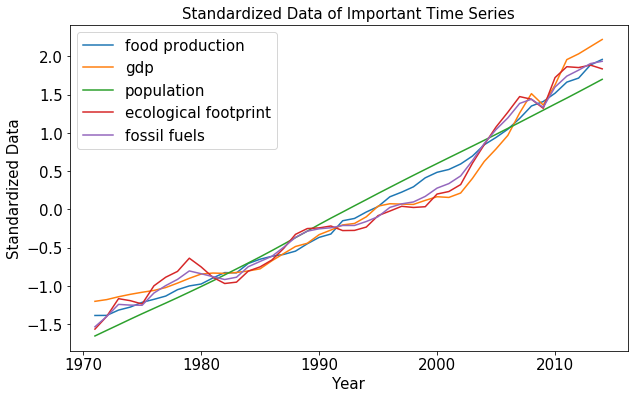

In [21]:
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sklearn.preprocessing
import matplotlib
start_year = '1971'
end_year = '2014'
decoder_train_start = '2000'
pred_years = 7
data = get_medium()
data = data[['food production','gdp','population','ecological footprint','fossil fuels']]
series = data.columns.values
plotdat = sklearn.preprocessing.scale(data)
print(plotdat.shape)
plt.figure(figsize=(10,6)) 
SMALL_SIZE = 15
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
for i in range(plotdat.shape[1]):
    plt.plot(range(int(start_year),plotdat.shape[0]+int(start_year)),plotdat[:,i].astype(np.float64))
plt.title('Standardized Data of Important Time Series')
plt.xlabel('Year')
plt.ylabel('Standardized Data')
plt.legend(['food production','gdp','population','ecological footprint','fossil fuels'])
plt.savefig('important_data.pdf', bbox_inches='tight')
plt.show()
#plt.savefig('important_data.pdf', bbox_inches='tight')

In [12]:
encoder_input_data, decoder_target_data, pred_target, mean_data = transform_series(data, int(start_year), 
                                                                        int(decoder_train_start), pred_years)


# LSTM Encoder Decoder Architecture

In [4]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

latent_dim = 75 # LSTM hidden units
dropout = .40

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

C:\tools\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
batch_size = 200
epochs = 50
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model.compile(Adam(), loss='mean_squared_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0)

Epoch 1/50
20/20 [==============================] - 2s 104ms/step - loss: 0.0676
Epoch 2/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0670
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0606
Epoch 4/50
20/20 [==============================] - 0s 996us/step - loss: 0.0565
Epoch 5/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0503
Epoch 6/50
20/20 [==============================] - 0s 997us/step - loss: 0.0450
Epoch 7/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0397
Epoch 8/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0387
Epoch 9/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0402
Epoch 10/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0340
Epoch 11/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0283
Epoch 12/50
20/20 [==============================] - 0s 997us/step - loss: 0.0238
Epoch 13/50
20/20 [======================

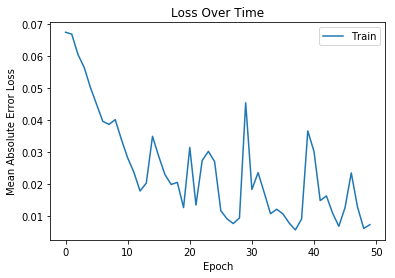

In [6]:
plt.plot(history.history['loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train'])

In [7]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq, pred_steps):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

0.07167807699067318


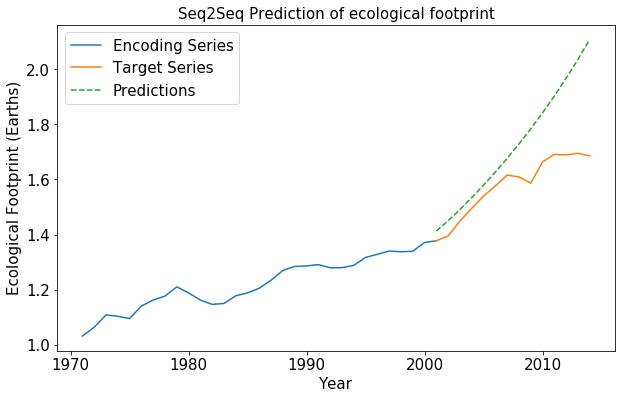

In [12]:
predict_and_plot_all(encoder_input_data, decoder_target_data, pred_target, mean_data, 14, 
                     int(end_year) - int(decoder_train_start), int(start_year), series,  [18])

In [ ]:
ax = plt.subplot(1,1,1)   
        color=iter(cm.rainbow(np.linspace(0,1,i)))
        c=next(color)
        ax.plot(range(start_year,x_encode + 1),encode_series_tail, color = c)
        ax.plot(range(x_encode,x_encode+target_series.size),target_series, color = c)
        ax.plot(range(x_encode,x_encode+pred_steps),pred_series,linestyle='--', color = c)
        kwargs = {'color': c, 'linewidth': 2, 'linestyle': '-'}
        ax.plot([], [], label=series[sample_ind], **kwargs)

In [ ]:
[12, 13, 17, 18, 19]
range(encoder_input_data.shape[0])

In [ ]:
for i in range(19,20):
    print(i)